---
title: SIS 10.2-1
author: k.wodehouse & s.blough
format:
    html:
        self-contained: true
        code-fold: show
---

# part a

using `IDEAL` model in aspen and going to binary analysis

here's what my analysis page looked like when running these different models

![image](unifac%20analysis.JPG)

I'll work through the data wrangling for the first part of this quesiton

In [28]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('ideal.tsv', sep='\t')
pres = df['TOTAL PRES']
xe, xh, ye, yh = np.array(df['LIQUID1 MOLEFRAC ETHYL-01']), np.array(df['LIQUID1 MOLEFRAC N-HEP-01']), np.array(df['VAPOR MOLEFRAC ETHYL-01']), np.array(df['VAPOR MOLEFRAC N-HEP-01'])

interp_p = interp1d(xe, pres, kind='linear', fill_value="extrapolate")
interp_e = interp1d(xe, ye, kind='linear', fill_value="extrapolate")
interp_h = interp1d(xh, yh, kind='linear', fill_value="extrapolate")

df.head(3)

,TEMP,MOLEFRAC ETHYL-01,TOTAL PRES,TOTAL KVL ETHYL-01,TOTAL KVL N-HEP-01,LIQUID1 GAMMA ETHYL-01,LIQUID1 GAMMA N-HEP-01,LIQUID2 GAMMA ETHYL-01,LIQUID2 GAMMA N-HEP-01,TOTAL KVL2 ETHYL-01,TOTAL KVL2 N-HEP-01,TOTAL BETA,VAPOR MOLEFRAC ETHYL-01,VAPOR MOLEFRAC N-HEP-01,LIQUID1 MOLEFRAC ETHYL-01,LIQUID1 MOLEFRAC N-HEP-01,LIQUID2 MOLEFRAC ETHYL-01,LIQUID2 MOLEFRAC N-HEP-01
0,30,0.00,0.077455,9.709034,1.000000,1,1,NaN,NaN,NaN,NaN,1,0.000000,1.000000,0.00,1.00,NaN,NaN
1,30,0.01,0.084201,8.931212,0.919887,1,1,NaN,NaN,NaN,NaN,1,0.089312,0.910688,0.01,0.99,NaN,NaN
2,30,0.02,0.090947,8.268773,0.851658,1,1,NaN,NaN,NaN,NaN,1,0.165375,0.834625,0.02,0.98,NaN,NaN


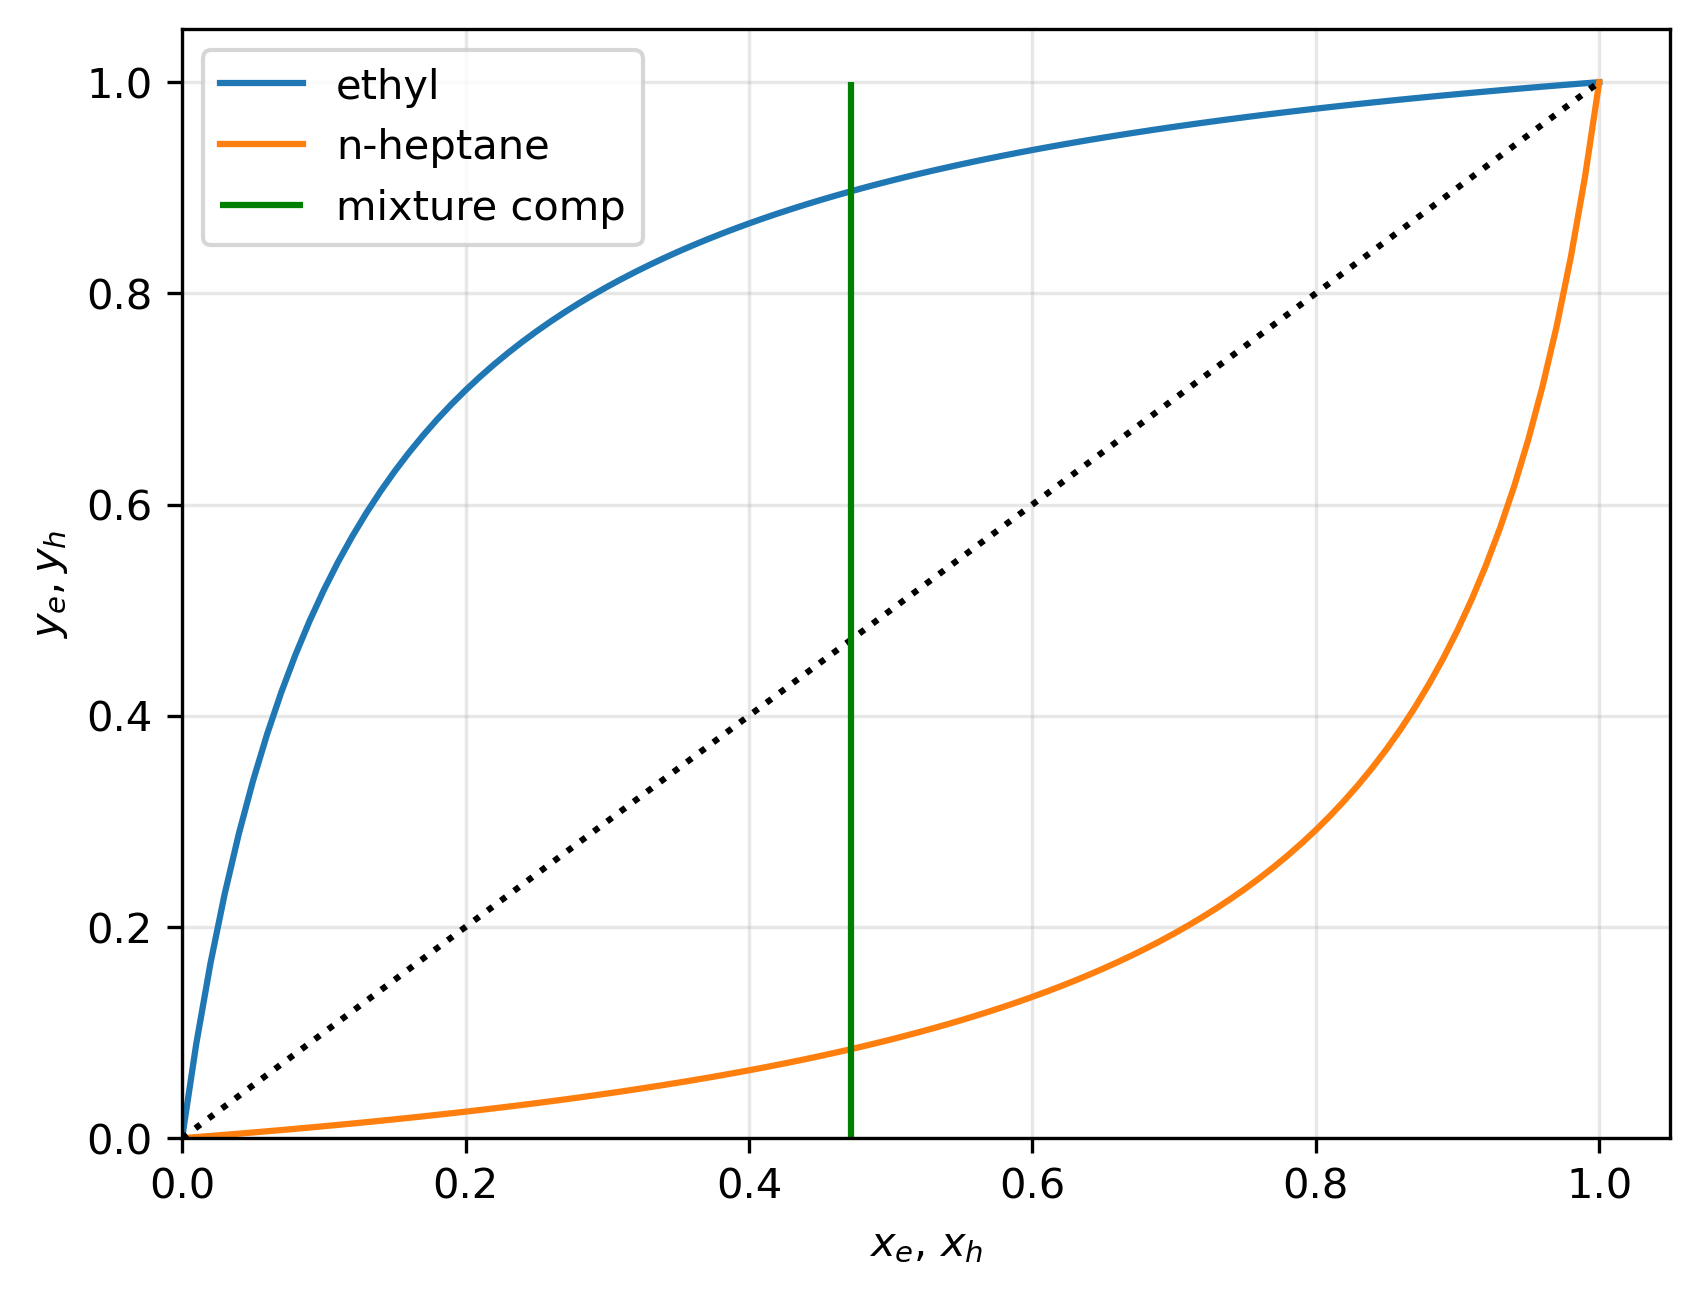

In [29]:
fig, ax = plt.subplots(dpi=300)
ax.grid(alpha=0.3)
ax.plot(xe,ye, label='ethyl')
ax.plot(xh,yh, label='n-heptane')
ax.plot(xe, xe, ':', c='black')
ax.set(xlim=0, ylim=0, xlabel='$x_e$, $x_h$', ylabel='$y_e, y_h$')
ax.vlines(0.4723, 0,1, color='green', label='mixture comp')
ax.legend();

In [30]:
print('----- vapor composition -----')
print(f'ethyl bromide: {interp_e(0.4723):.4f}')
print(f'n-heptane: {interp_h(0.4723):.4f}')
print(f'sum: {interp_h(0.4723) + interp_e(0.4723):.4f} \t(not so good)')
print('----- pressure -----')
print(f'{interp_p(0.4723):.4f} bar')

----- vapor composition -----
ethyl bromide: 0.8968
n-heptane: 0.0844
sum: 0.9812 	(not so good)
----- pressure -----
0.3961 bar


I'll make a convenience function to call for the other reports that need generated

In [31]:
def generate_report(filename):
    df = pd.read_csv(filename, sep='\t')
    pres = df['TOTAL PRES']

    xe, xh, ye, yh = np.array(df['LIQUID1 MOLEFRAC ETHYL-01']), np.array(df['LIQUID1 MOLEFRAC N-HEP-01']), np.array(df['VAPOR MOLEFRAC ETHYL-01']), np.array(df['VAPOR MOLEFRAC N-HEP-01'])

    interp_p, interp_e, interp_h = [interp1d(xe, x, kind='linear', fill_value="extrapolate") for x in [pres, ye, yh]]

    fig, ax = plt.subplots(dpi=300)
    ax.grid(alpha=0.3)
    ax.plot(xe,ye, label='ethyl')
    ax.plot(xh,yh, label='n-heptane')
    ax.plot(xe, xe, ':', c='black')
    ax.set(xlim=0, ylim=0, xlabel='$x_e$, $x_h$', ylabel='$y_e, y_h$')
    ax.vlines(0.4723, 0,1, color='green', label='mixture comp')
    ax.legend()

    interpolated_eb, interpolated_nh, interpolated_p = [f(0.4723) for f in [interp_e, interp_h, interp_p]]
    print('----- vapor composition -----')
    print(f'ethyl bromide: {interpolated_eb:.4f}')
    print(f'n-heptane: {interpolated_nh:.4f}')
    print(f'sum: {interpolated_nh + interpolated_eb:.4f}')
    print('----- pressure -----')
    print(f'{interpolated_p:.4f} bar')

# part b

here's what the p-x-y plot looked like for the `GRAYSON` model

![image](ptb_plot.png)

----- vapor composition -----
ethyl bromide: 0.8903
n-heptane: 0.1097
sum: 1.0000
----- pressure -----
0.4558 bar


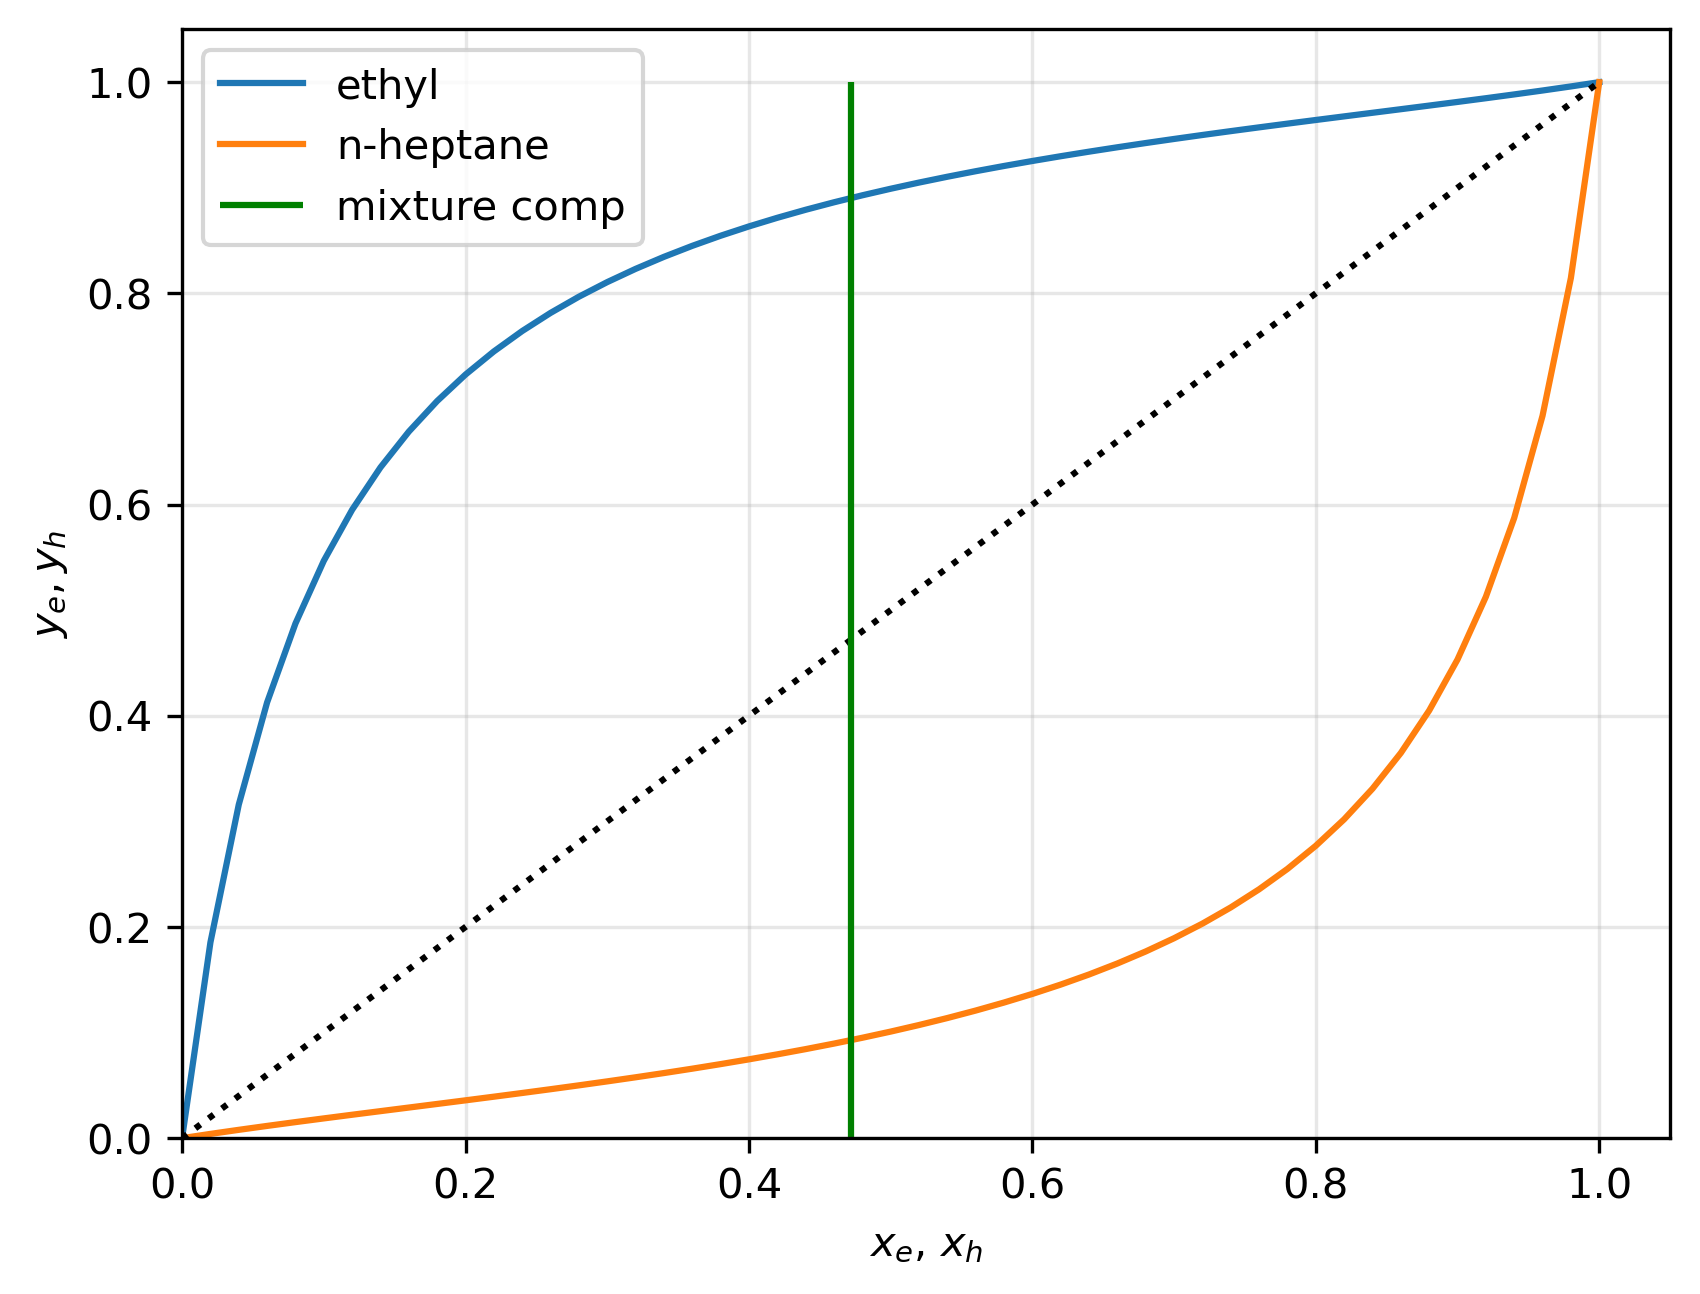

In [32]:
generate_report('ptb.tsv')

# part c

here's what the p-x-y plot looked like for the `UNIFAC` model

![image](unifac%20plot.JPG)

----- vapor composition -----
ethyl bromide: 0.8984
n-heptane: 0.1016
sum: 1.0000
----- pressure -----
0.4599 bar


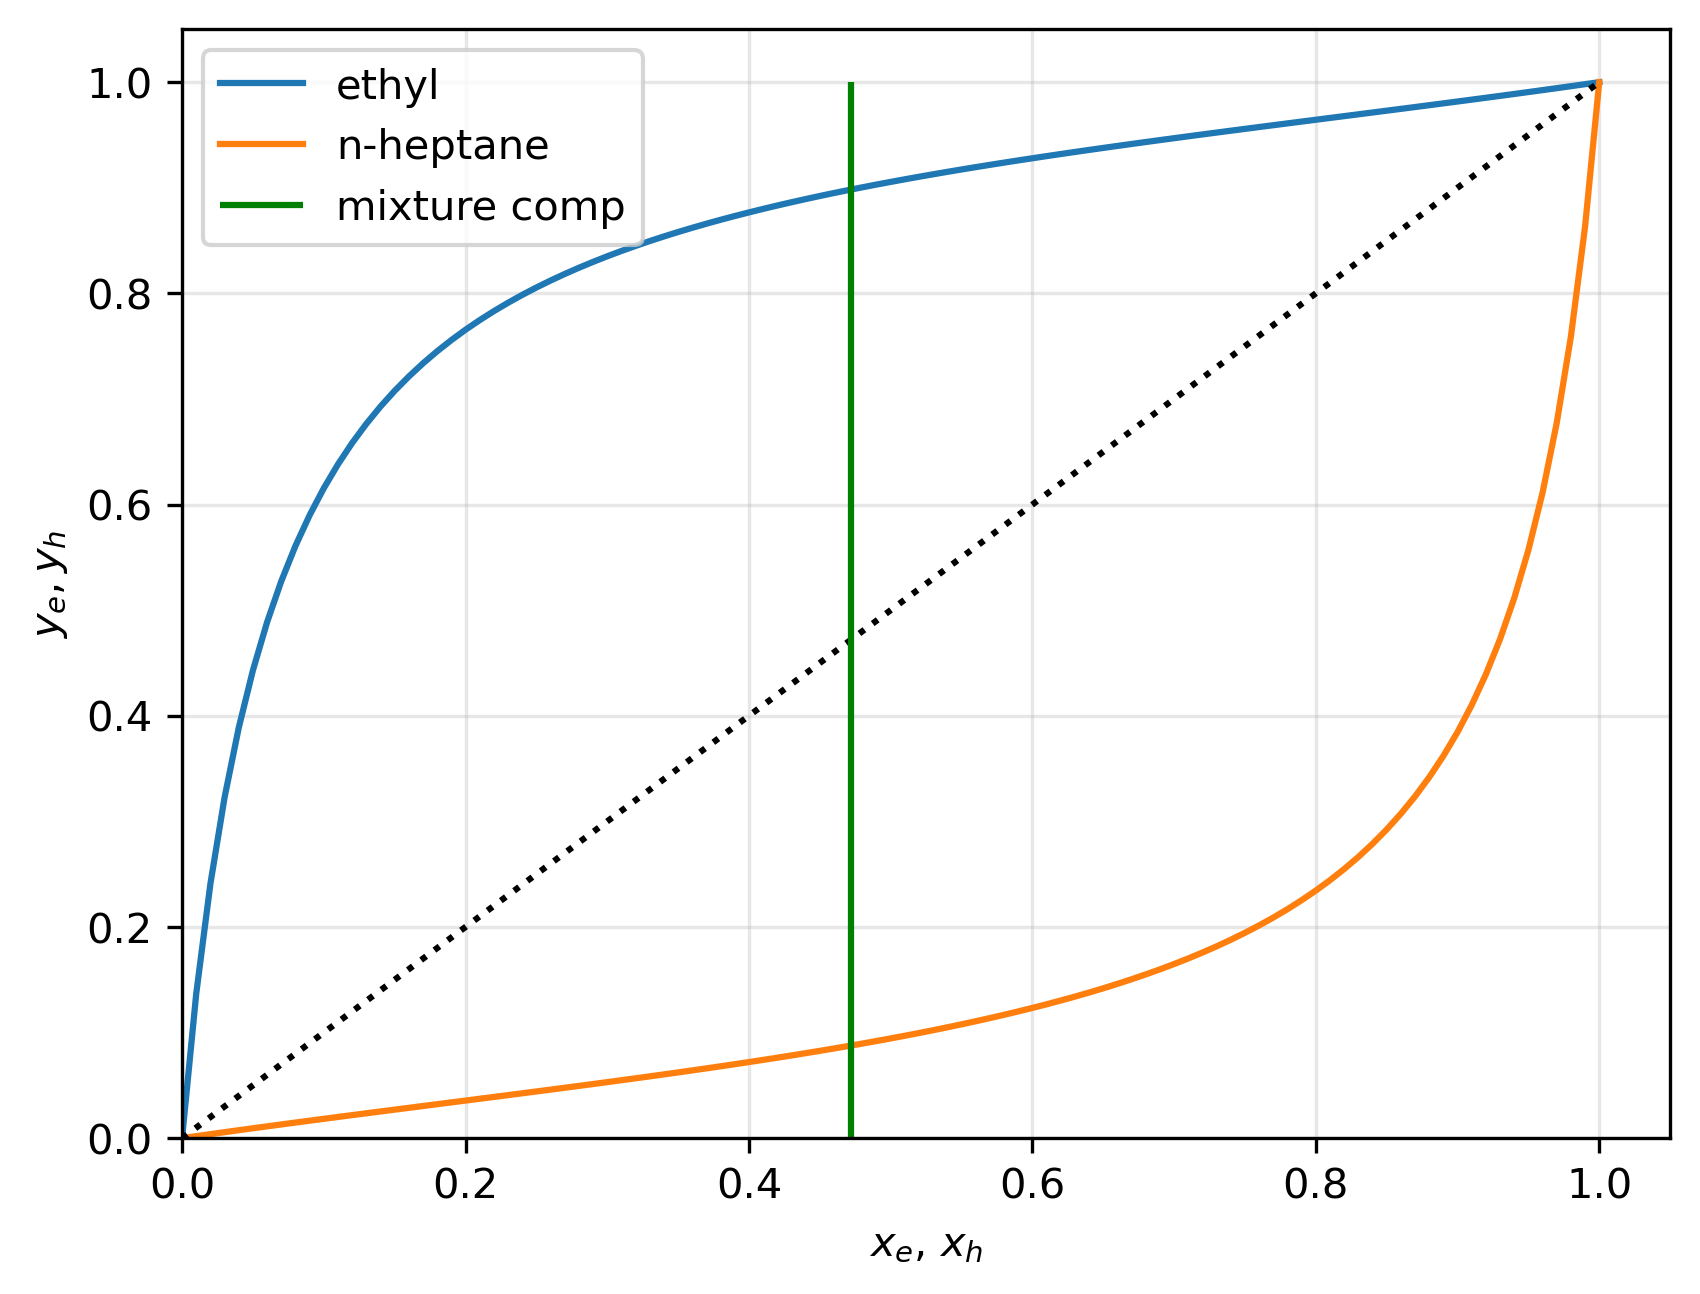

In [33]:
generate_report('unifac.tsv')

# part d

we can start by calculating the activity coefficents using this equation

$$
\gamma_i = \frac{y_i P_{\text{total}}}{x_i P^{\text{vap}}_i} 
$$

the van laar parameters using these equations from the textbook in chapter 9

$$
\alpha = \left( 1 + \frac{x_2 \ln \gamma_2}{x_1 \ln \gamma_1} \right)^2 \ln \gamma_1 \tag{9.5-10}
$$

$$
\beta = \left( 1 + \frac{x_1 \ln \gamma_1}{x_2 \ln \gamma_2} \right)^2 \ln \gamma_2
$$

where 1 is ethyl bromide and 2 is n-heptane

In [34]:
ye = 0.815
yh = 1 - ye
xe = 0.2843
xh = 1 - xe

pvap_e = 0.7569
pvap_h = 0.0773

Ptotal = 0.3197
T = 273.15 + 30.0

gammae = ye * Ptotal / (xe * pvap_e)
gammah = yh * Ptotal / (xh * pvap_h)
print(f'gamma ethyl bromide: {gammae:.4f}')
print(f'gamma n-heptane : {gammah:.4f}\n')

alpha = (1 + (xh * np.log(gammah))/(xe * np.log(gammae)))**2 * np.log(gammae)
print(f'alpha: {alpha:.8f}')
beta = (1 + (xe * np.log(gammae))/(xh * np.log(gammah)))**2 * np.log(gammah)
print(f'beta: {beta:.8f}')

gamma ethyl bromide: 1.2108
gamma n-heptane : 1.0691

alpha: 0.67529999
beta: 0.30524933


These can be fed into aspen by noticing $A_{12} = \alpha$ and $A_{21} = \beta$ 

![image](vanlaarINPUT2.png)

![image](vanlaarPLOT2.png)


----- vapor composition -----
ethyl bromide: 0.8895
n-heptane: 0.1105
sum: 1.0000
----- pressure -----
0.4224 bar


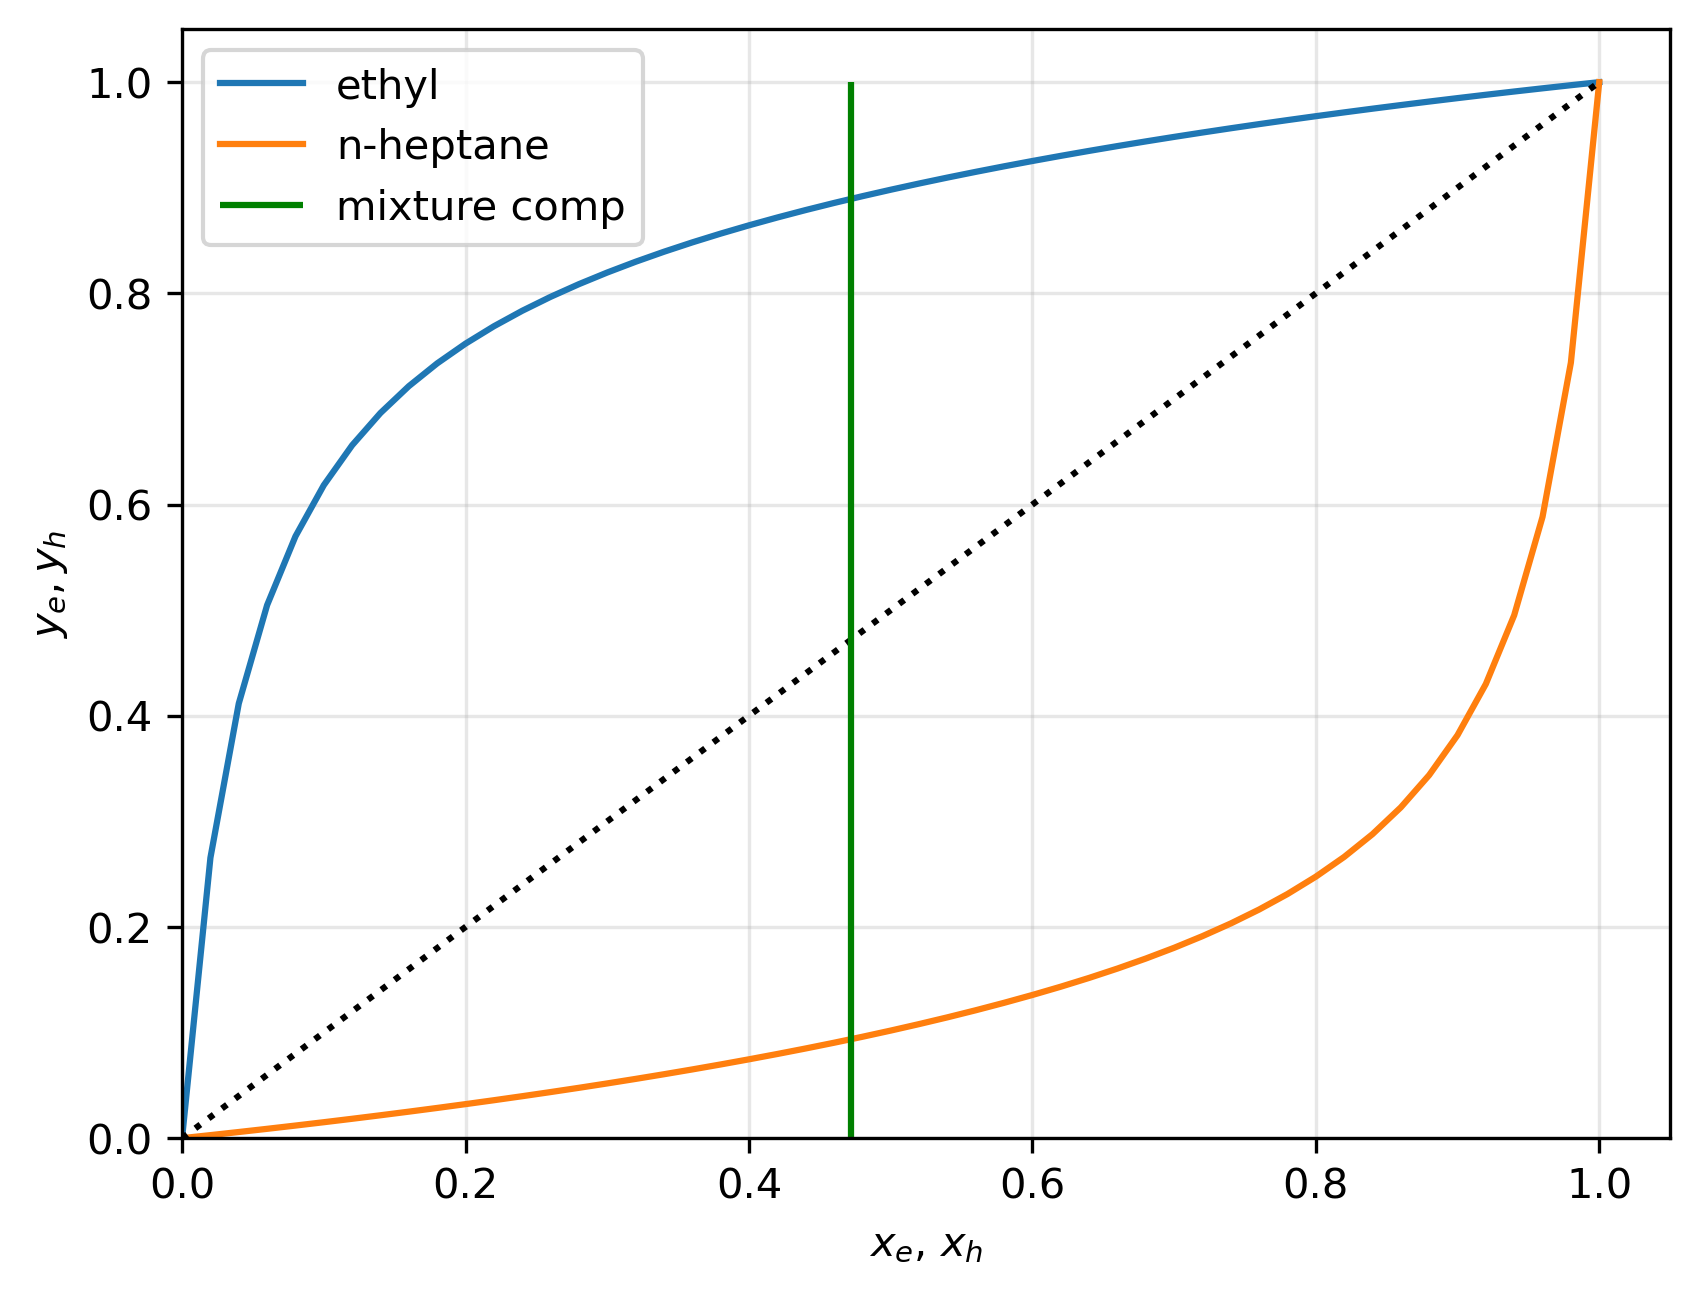

In [35]:
generate_report('vanlaar.tsv')

In [36]:
# filler